### Downloading the dependencies

In [51]:
%pip install scikit-learn numpy pandas matplotlib opencv-python seaborn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Program Files\Python310\python.exe -m pip install --upgrade pip' command.


### Importing the libraries

In [1]:
import os
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as rnd
from sklearn.metrics import silhouette_score
import cv2
import seaborn as sns
from sklearn.metrics import confusion_matrix

# K-Means Clustering on Image Data
##### Name: Pranshu Pandya(200101073)

<a class="anchor" id="0.1"></a>
# **Table of Contents**


1.	[What is Clustering?](#1)
1.  [Introduction to K-Means Clustering](#2)
1.	[K-Means Clustering intuition](#3)
1.  [Implementing the K-means Clustering from Scratch](#4)
1.	[Introducing the MNIST dataset](#5)
1.  [Applying K-Means Clustering with random centroid initialization on the raw image data*](#6)
1.  [Applying feature selection using PCA](#7)
1.  [Applying feature selection using Histogram of Oriented Gradients(HOG)](#8)
1.	[Results and conclusion](#9)
1.  [References](#10)


# **1. What is Clustering?** <a class="anchor" id="1"></a>



In Machine Learning, the types of Learning can broadly be classified into three types: 

1. Supervised Learning,  
2. Unsupervised Learning and   
3. Semi-supervised Learning.  

Algorithms belonging to the family of Unsupervised Learning have no variable to predict tied to the data. Instead of having an output, the data only has an input which would be multiple variables that describe the data. This is where clustering comes in.

Clustering is the task of grouping together a set of objects in a way that objects in the same cluster are more similar to each other than to objects in other clusters. Similarity is a metric that reflects the strength of relationship between two data objects. Clustering is mainly used for exploratory data mining. It has manifold usage in many fields such as machine learning, pattern recognition, image analysis, information retrieval, bio-informatics, data compression, and computer graphics.

# **2. Introduction to K-Means Clustering** <a class="anchor" id="2"></a>



**K-Means clustering** is the most popular unsupervised learning algorithm. It is used when we have unlabelled data which is data without defined categories or groups. The algorithm follows an easy or simple way to classify a given data set through a certain number of clusters, fixed apriori. K-Means algorithm works iteratively to assign each data point to one of K groups based on the features that are provided. Data points are clustered based on feature similarity.

K-Means clustering can be represented diagrammatically as follows:-

![K-Means](./clustering%20example.png)

In the above image we can see that the data points are grouped into three clusters around the imaginary centroids of the cluster points.

# **3. K-Means Clustering intuition** <a class="anchor" id="3"></a>

[Table of Contents](#0.1)




K-Means clustering is used to find intrinsic groups within the unlabelled dataset and draw inferences from them. It is based on centroid-based clustering.


**Centroid** - A centroid is a data point at the centre of a cluster. In centroid-based clustering, clusters are represented by a centroid. It is an iterative algorithm in which the notion of similarity is derived by how close a data point is to the centroid of the cluster.
K-Means clustering works as follows:-
The K-Means clustering algorithm uses an iterative procedure to deliver a final result. The algorithm requires number of clusters K and the data set as input. The data set is a collection of features for each data point. The algorithm starts with initial estimates for the K centroids. The algorithm then iterates between two steps:-


## **3.1 Data assignment step**


Each centroid defines one of the clusters. In this step, each data point is assigned to its nearest centroid, which is based on the squared Euclidean distance. So, if ci is the collection of centroids in set C, then each data point is assigned to a cluster based on minimum Euclidean distance. 



## **3.2 Centroid update step**


In this step, the centroids are recomputed and updated. This is done by taking the mean of all data points assigned to that centroid’s cluster. 


The algorithm then iterates between step 1 and step 2 until a stopping criteria is met. Stopping criteria means no data points change the clusters, the sum of the distances is minimized or some maximum number of iterations is reached.
This algorithm is guaranteed to converge to a result. The result may be a local optimum meaning that assessing more than one run of the algorithm with randomized starting centroids may give a better outcome.

The K-Means intuition can be represented with the help of following diagram:-

![Kmeans Intuition](./K_means_intution.png)

# **4.Implementing K-Means clustering from scratch** <a class="anchor" id="4"></a>

In [98]:
class KMeans:
    """
    K-Means clustering algorithm implementation.

    Attributes:
        n_clusters (int): The number of clusters to form.
        max_iter (int): The maximum number of iterations to run.
        tol (float): Convergence tolerance for centroid updates.
        init (str): Method for initializing centroids, default 'random'.
            Options: 'random', 'k-means++'
        random_state (int): Random seed for reproducibility.
    """

    def __init__(self, n_clusters=8, max_iter=300, tol=1e-4, init='random', random_state=None):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.init = init
        self.random_state = random_state
        self.centroids_ = None
        self.labels_ = None

    def _initialize_centroids(self, X):
        """
        Initializes centroids based on the chosen initialization method.

        Args:
            X (numpy.ndarray): The data to be clustered.
        """
        np.random.seed(self.random_state)  # For reproducibility

        if self.init == 'random':
            # Randomly select data points as initial centroids
            indices = np.random.choice(X.shape[0], self.n_clusters, replace=False)
            self.centroids_ = X[indices]

        # elif self.init == 'k-means++':
        #     # Implement K-Means++ initialization for better centroid placement
        #     self.centroids_ = _kmeans_plusplus(X, self.n_clusters, random_state=self.random_state)

        else:
            raise ValueError(f"Unknown initialization method: {self.init}")

    def _find_closest_centroids(self, X):
        """Assigns data points to their closest centroids.

        Args:
            X (numpy.ndarray): The data to be clustered.

        Returns:
            numpy.ndarray: Labels (indices) of the closest centroids for each data point.
        """
        distances = np.linalg.norm(X[:, None] - self.centroids_, axis=2)  # Efficient distance calculation
        return np.argmin(distances, axis=1)

    def _update_centroids(self, X):
        """Updates centroids as the mean of data points in their respective clusters.

        Args:
            X (numpy.ndarray): The data to be clustered.
        """
        for i in range(self.n_clusters):
            cluster_points = X[self.labels_ == i]
            self.centroids_[i] = cluster_points.mean(axis=0) if cluster_points.size > 0 else self.centroids_[i]

    def fit(self, X):
        """Fits the K-Means model to the data.

        Args:
            X (numpy.ndarray): The data to be clustered with shape (n_samples, n_features).
        """
        self._initialize_centroids(X)

        for _ in range(self.max_iter):
            old_centroids = self.centroids_
            self.labels_ = self._find_closest_centroids(X)
            self._update_centroids(X)

            # Check for convergence
            if np.all(np.abs(old_centroids - self.centroids_) < self.tol):
                break

        return self

    def predict(self, X):
        """Predicts cluster labels for new data points.

        Args:
            X (numpy.ndarray): The new data to predict.

        Returns:
            numpy.ndarray: Predicted cluster labels.
        """
        return self._find_closest_centroids(X)

# **5. Introducing the MNIST image dataset** <a class="anchor" id="5"></a>

The MNIST dataset is a widely-used benchmark dataset in the field of machine learning. It consists of a collection of 28x28 pixel grayscale images of handwritten digits (0-9) along with their corresponding labels. The dataset is divided into a training set containing 60,000 examples and a test set containing 10,000 examples.

### Dataset Details:

- **Format**: The dataset is provided in a format where each image is represented as a 28x28 matrix of pixel values, with each pixel value ranging from 0 to 255 (indicating the intensity of the pixel).
- **Labels**: Each image is associated with a label indicating the digit it represents.

In [99]:
def load_mnist(dataset_dir=".", create_dir=False):
    """Loads MNIST and saves it locally.

    Args:
        dataset_dir (str): The directory to save the dataset.
        create_dir (bool):  If True, creates the directory if it doesn't exist.  
    """

    save_path = os.path.join(dataset_dir, "mnist")
    os.makedirs(dataset_dir, exist_ok=create_dir)  # Create directory if needed

    if os.path.exists(save_path + ".npz"):
        print("MNIST dataset already saved - loading from disk")
        data = np.load(save_path + ".npz", allow_pickle=True)
        X = data['X']
        y = data['y']
    else:
        print("Downloading MNIST dataset...")
        mnist = fetch_openml('mnist_784', version=1, data_home=dataset_dir)
        X, y = mnist["data"], mnist["target"]
        np.savez_compressed(save_path, X=X, y=y)  # Save to file
    # stratifiedly select the 1000 examples where there is equal number of samples from each of the 10 types of images
    import pandas as pd
    df = pd.DataFrame(X)
    df['label'] = y
    df = df.groupby('label').apply(lambda x: x.sample(100, random_state=1))
    X = df.drop('label', axis=1).values
    y = df['label'].values
    return X, y


# Example Usage
DATA_DIR = "./datasets"  # Your desired directory
X, y = load_mnist(dataset_dir=DATA_DIR, create_dir=True)

MNIST dataset already saved - loading from disk


C:\Users\prans\AppData\Local\Temp\ipykernel_2436\819158598.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('label').apply(lambda x: x.sample(100, random_state=1))


### 5.1 Visulizing the dataset

1. Displaying Random Images

This code directly displays a few random images from the MNIST dataset.
Understanding: Helps get a visual sense of the handwritten digits' variability and potential imperfections/noise in the data.

2. Histogram of Digit Frequencies

The histogram plots the frequency of each digit (0-9) in the training set.
Insights: Visualizes whether the classes are roughly equally represented, or if there's any significant imbalance.

In [100]:
y # label for the image

array(['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1

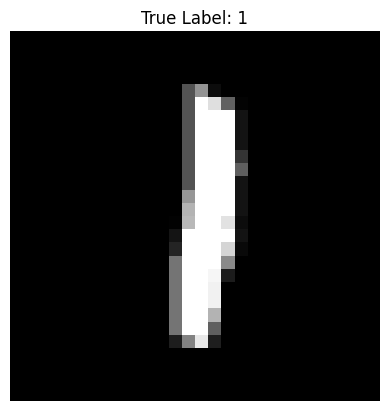

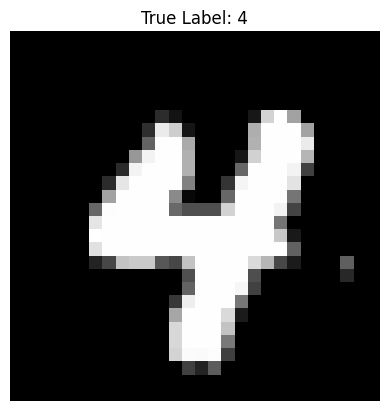

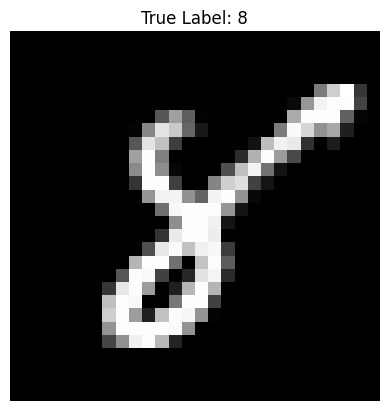

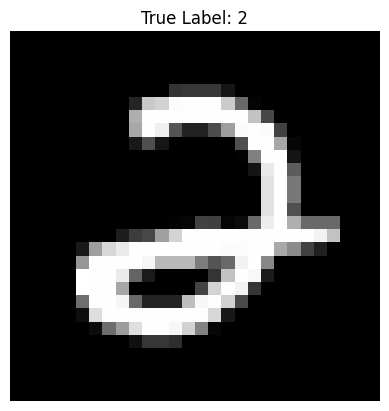

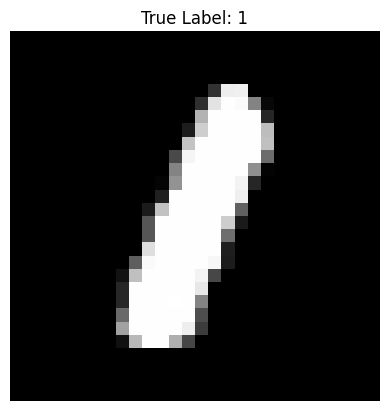

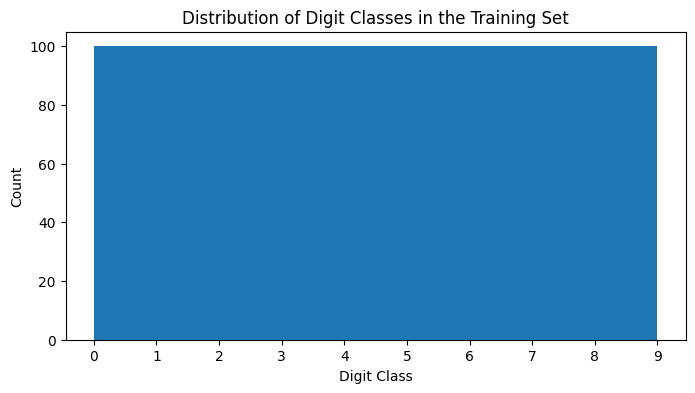

In [101]:
def display_digit(image_row, label):
    """Displays an MNIST image from a DataFrame row (pixel1 to pixel784) with label"""
    image_array = image_row.reshape(28, 28)  
    plt.imshow(image_array, cmap='gray')  
    plt.title(f"True Label: {label}")
    plt.axis('off')
    plt.show()

# 1. Visualize a few random samples
rnd.seed(42)  # For reproducibility
for i in range(5):
    index = rnd.randint(0, len(X))
    display_digit(X[index], y[index])


# 2. Plot a histogram of digit frequencies
plt.figure(figsize=(8,4))
plt.hist(y, bins=10)
plt.xlabel('Digit Class')
plt.ylabel('Count')
plt.title('Distribution of Digit Classes in the Training Set')
plt.show()

We can see that the distribution of the digits are balanced in the dataset as we have selected 100 example of each of the digit.

# **6.Applying K-Means Clustering with random centroid initialization on the raw image data** <a class="anchor" id="6"></a>

In [132]:
preprocessed_img = X

In [103]:
kmeans = KMeans(n_clusters=10, init='random', random_state=42)

# Fit the model
kmeans.fit(preprocessed_img)

# Get cluster assignments
cluster_labels = kmeans.labels_

In [104]:
cluster_labels

array([0, 3, 5, 6, 6, 8, 1, 6, 6, 6, 9, 6, 8, 6, 1, 6, 5, 5, 7, 0, 0, 0,
       5, 0, 0, 1, 6, 6, 0, 0, 6, 6, 5, 0, 2, 5, 8, 8, 0, 6, 5, 6, 6, 0,
       6, 6, 6, 6, 5, 8, 9, 7, 9, 3, 7, 6, 6, 0, 3, 7, 0, 6, 5, 6, 8, 6,
       6, 7, 2, 0, 0, 6, 7, 5, 5, 0, 6, 6, 0, 0, 0, 0, 6, 0, 6, 0, 0, 5,
       0, 8, 5, 6, 0, 5, 0, 0, 7, 1, 6, 3, 3, 9, 9, 3, 9, 9, 3, 9, 3, 3,
       3, 3, 3, 3, 9, 9, 9, 3, 9, 9, 9, 9, 9, 9, 3, 9, 9, 9, 9, 3, 3, 9,
       9, 9, 3, 3, 9, 3, 9, 9, 3, 9, 9, 9, 3, 9, 9, 3, 9, 3, 3, 9, 9, 9,
       3, 3, 9, 9, 9, 9, 3, 9, 3, 3, 9, 3, 9, 9, 3, 9, 9, 3, 3, 9, 9, 3,
       9, 9, 9, 3, 3, 3, 9, 3, 7, 3, 3, 3, 3, 9, 9, 9, 9, 9, 3, 9, 9, 9,
       9, 9, 6, 5, 3, 3, 9, 4, 9, 4, 3, 3, 9, 3, 9, 3, 7, 7, 7, 3, 3, 6,
       3, 4, 5, 3, 1, 5, 8, 1, 3, 5, 3, 3, 9, 9, 9, 2, 5, 9, 8, 3, 4, 5,
       3, 3, 3, 3, 4, 2, 3, 3, 3, 9, 5, 9, 3, 5, 3, 7, 8, 8, 9, 3, 8, 3,
       9, 3, 3, 9, 3, 9, 3, 5, 3, 3, 4, 3, 3, 3, 3, 3, 9, 3, 5, 5, 3, 9,
       3, 9, 9, 5, 5, 3, 8, 9, 8, 9, 4, 9, 3, 9, 7,

### 6.1 Simple Distribution Plot 
<a class="anchor" id="6.1"></a>

Purpose: Get a quick overview of how many samples are assigned to each cluster.

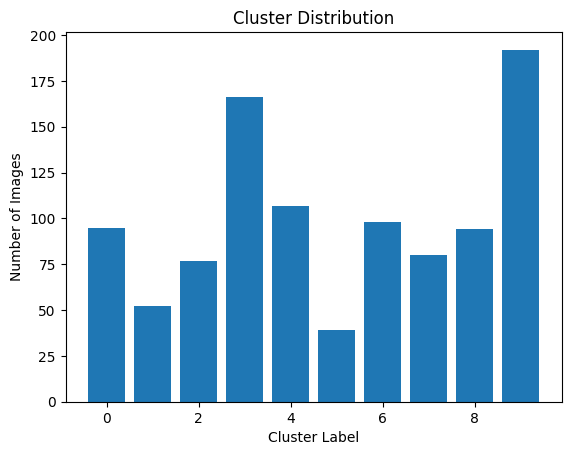

In [105]:
unique_labels, counts = np.unique(cluster_labels, return_counts=True)

plt.bar(unique_labels, counts)
plt.xlabel("Cluster Label")
plt.ylabel("Number of Images")
plt.title("Cluster Distribution")
plt.show()

We can see that the distribution is far from the original distribution we can see in the earlier plot. This is because the K-Means algorithm is trying to group the data points based on the pixel values, which may not necessarily correspond to the actual digit labels.

### 6.2 Visualization Using PCA for Dimensionality Reduction

Purpose: See if clusters visually separate in a reduced 2D space (PCA can help here).

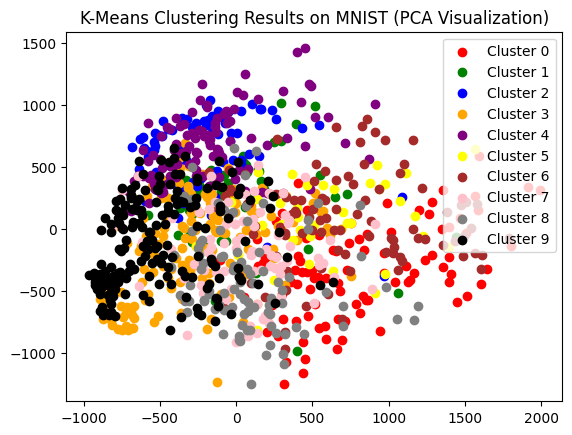

In [106]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)  # Assuming X is your image data (NumPy array)

colors = ['red', 'green', 'blue', 'orange', 'purple', 'yellow', 'brown', 'pink', 'gray', 'black']  

for cluster_id in range(10):
    cluster_indices = np.where(cluster_labels == cluster_id)
    plt.scatter(X_reduced[cluster_indices, 0], 
                X_reduced[cluster_indices, 1],
                c=colors[cluster_id], label=f"Cluster {cluster_id}")

plt.legend()
plt.title("K-Means Clustering Results on MNIST (PCA Visualization)")
plt.show()


here we can see that the clusters are not well separated in the 2D space.

### 6.3 Displaying Sample Images From Clusters

Purpose: Directly inspect what kind of images are grouped together.

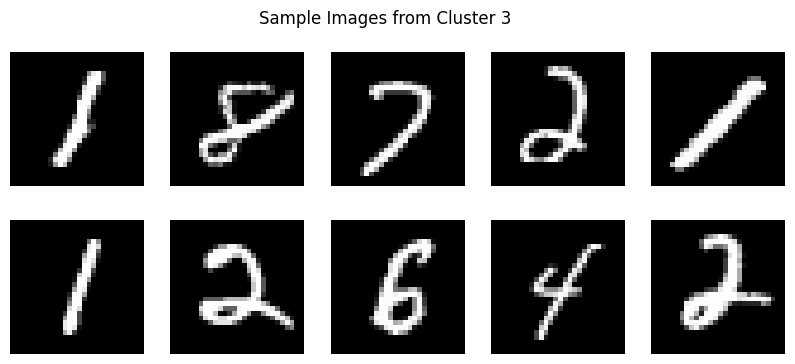

In [107]:
def display_cluster_images(cluster_id, n_images=10):
    cluster_indices = np.where(cluster_labels == cluster_id)[0]
    np.random.seed(40)  # For reproducibility
    sample_indices = np.random.choice(cluster_indices, n_images, replace=False)
    
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 4))  # Adjust if you want a different grid 
    
    for i, ax in enumerate(axes.flat):
        if i < n_images:
            image = preprocessed_img[sample_indices[i]].reshape(28, 28)
            ax.imshow(image, cmap='gray')
            ax.axis('off')
        else:
            ax.set_visible(False)  # Hide unused axes 
    plt.suptitle(f"Sample Images from Cluster {cluster_id}")
    plt.show()

# Example usage:
display_cluster_images(cluster_id=3, n_images=10)  

we can see that we are having quite mix images in the cluster as without proper feature extraction the K-Means algorithm is not able to group the images properly.

In [108]:
silhouette_score(preprocessed_img, cluster_labels)

0.03319873532819858

### 6.4 Plotting confusion metric

Confusion Matrix:
 [[27  4  2  4  0 14 32  7  7  3]
 [ 0  0  0 40  0  0  0  1  0 59]
 [ 0  2  2 41  7 13  2  4  7 22]
 [21  1  3  5  0  0  6 21 32 11]
 [ 0 15  1 16 54  1  0  0  2 11]
 [36  2  0 12  1  0  3 27 11  8]
 [ 0  6  0 21  1  9 53  0  1  9]
 [ 0  7 54  3 13  0  0  1  1 21]
 [10  0  1 19  4  2  2 15 30 17]
 [ 1 15 14  5 27  0  0  4  3 31]]


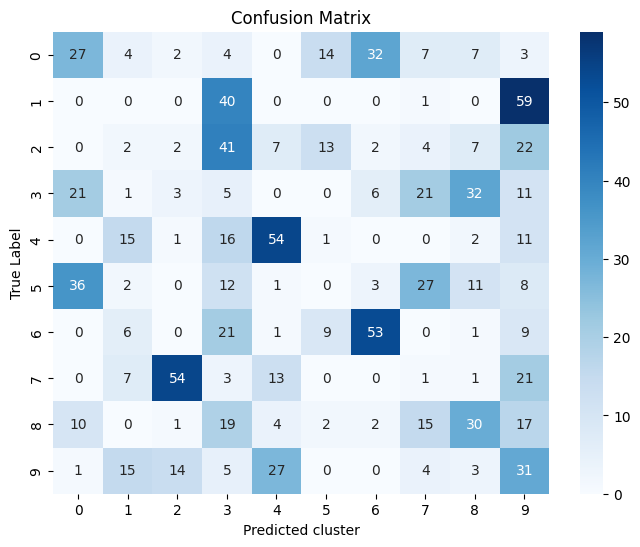

In [110]:
cm = confusion_matrix(y.astype('int'), cluster_labels)  # y_true are your true labels
print("Confusion Matrix:\n", cm)
plt.figure(figsize=(8, 6)) 
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')  # fmt='d' displays as integers
plt.xlabel("Predicted cluster")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

We can see that the True labels are scattered across the clusters and the K-Means algorithm is not able to group the images properly as we are not providing the proper features to the algorithm.

# **7. Applying feature selection using PCA** <a class="anchor" id="7"></a>

In [111]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Assuming X contains your MNIST image data
pca = PCA(n_components=50)  # Reduce to 50 dimensions
X_reduced = pca.fit_transform(X)


kmeans = KMeans(n_clusters=10, init='random', random_state=42)

# Fit the model
kmeans.fit(X_reduced)

# Get cluster assignments
cluster_labels = kmeans.labels_

### 7.1 Simple Distribution Plot

Purpose: Get a quick overview of how many samples are assigned to each cluster.

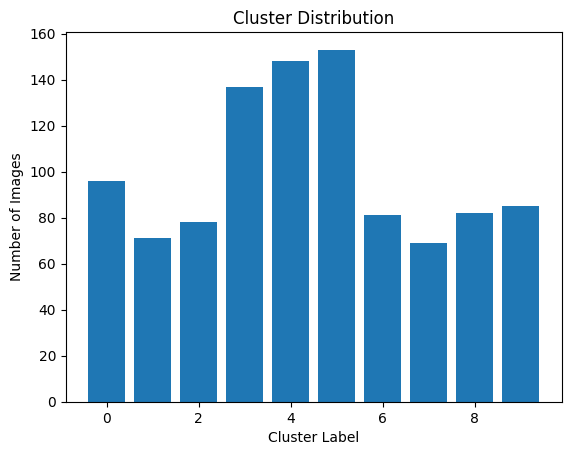

In [112]:
unique_labels, counts = np.unique(cluster_labels, return_counts=True)

plt.bar(unique_labels, counts)
plt.xlabel("Cluster Label")
plt.ylabel("Number of Images")
plt.title("Cluster Distribution")
plt.show()

We can see that the distribution is far from the original distribution we can see in the earlier plot. This is because the K-Means algorithm is trying to group the data points based on the pixel values, which may not necessarily correspond to the actual digit labels.

But this is improvement from the naive features we saw in [6.1](#6.1)

### 7.2 Visualization Using PCA for Dimensionality Reduction

Purpose: See if clusters visually separate in a reduced 2D space (PCA can help here).

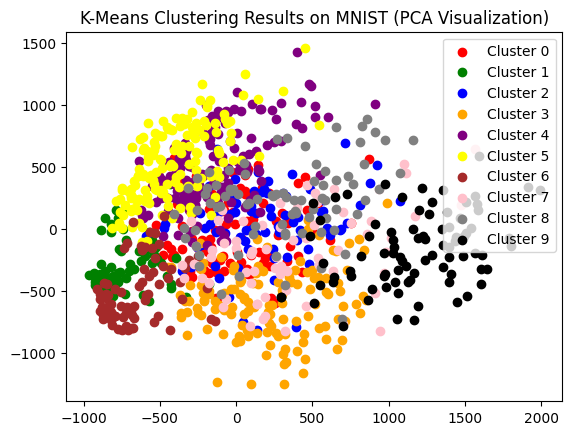

In [113]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)  # Assuming X is your image data (NumPy array)

colors = ['red', 'green', 'blue', 'orange', 'purple', 'yellow', 'brown', 'pink', 'gray', 'black']  

for cluster_id in range(10):
    cluster_indices = np.where(cluster_labels == cluster_id)
    plt.scatter(X_reduced[cluster_indices, 0], 
                X_reduced[cluster_indices, 1],
                c=colors[cluster_id], label=f"Cluster {cluster_id}")

plt.legend()
plt.title("K-Means Clustering Results on MNIST (PCA Visualization)")
plt.show()


here we can see that the clusters are not well separated in the 2D space.

### 7.3 Displaying Sample Images From Clusters

Purpose: Directly inspect what kind of images are grouped together.

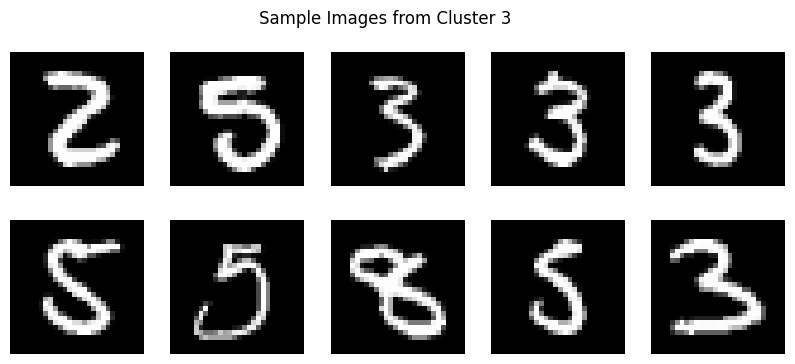

In [114]:
def display_cluster_images(cluster_id, n_images=10):
    cluster_indices = np.where(cluster_labels == cluster_id)[0]
    np.random.seed(40)  # For reproducibility
    sample_indices = np.random.choice(cluster_indices, n_images, replace=False)
    
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 4))  # Adjust if you want a different grid 
    
    for i, ax in enumerate(axes.flat):
        if i < n_images:
            image = preprocessed_img[sample_indices[i]].reshape(28, 28)
            ax.imshow(image, cmap='gray')
            ax.axis('off')
        else:
            ax.set_visible(False)  # Hide unused axes 
    plt.suptitle(f"Sample Images from Cluster {cluster_id}")
    plt.show()

# Example usage:
display_cluster_images(cluster_id=3, n_images=10)  

we can see that we are having quite mix images in the cluster as without proper feature extraction the K-Means algorithm is not able to group the images properly but one interesting thing is that it is getting confused between 3 and 5 which is quite reasonable.

In [115]:
silhouette_score(preprocessed_img, cluster_labels)

0.06151301609492498

We can see the improved silhoutte score when we use the PCA for feature extraction.

### 7.4 Plotting confusion metric


Confusion Matrix:
 [[ 1  0  0  3  1  0  0 19  3 73]
 [ 0 47  0  0  0  0 53  0  0  0]
 [ 0  1 72 10  2  1  7  4  2  1]
 [ 7  3  0 66  4  2  2 16  0  0]
 [ 1  4  2  0 52 38  1  0  2  0]
 [23  0  0 36  7  0  9 21  2  2]
 [ 1  2  1  0  6  0  5  8 72  5]
 [ 0  5  0  0 29 64  2  0  0  0]
 [62  3  3 22  1  3  1  1  1  3]
 [ 1  6  0  0 46 45  1  0  0  1]]


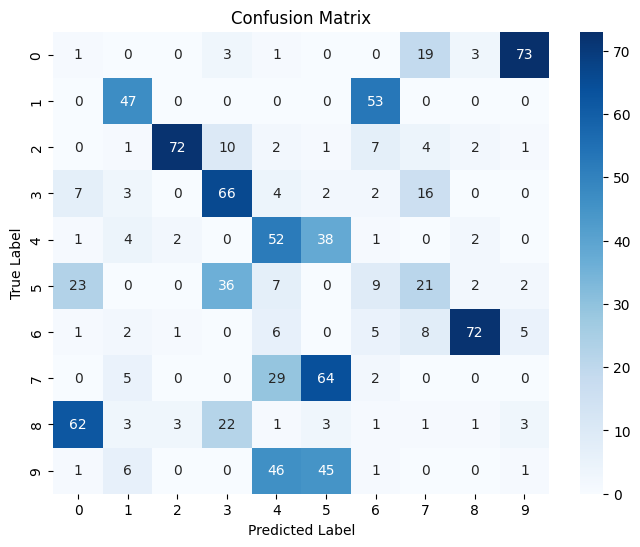

In [116]:
cm = confusion_matrix(y.astype('int'), cluster_labels)  # y_true are your true labels
print("Confusion Matrix:\n", cm)
plt.figure(figsize=(8, 6)) 
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')  # fmt='d' displays as integers
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

We can see the confusion matrix is improved from the previous one. There is still need more insights for separating digits like 3 and 5, also 4,7,9.

# **Bonus**: Histogram of Oriented Gradients (can skip if just interested in the implementation and analysis with K-Means)

## Histogram of Oriented Gradients (HOG) for Image Feature Extraction

In computer vision, image feature extraction plays a crucial role in tasks like object detection, image classification, and image retrieval. The Histogram of Oriented Gradients (HOG) is a powerful feature descriptor technique used to capture the local shape and texture information within an image. This tutorial will delve into the concept of HOG, its working principles, and its applications in image analysis.

**1. Gradients and Edge Detection**

* **Gradients:** The gradient of an image at a specific point represents the direction and magnitude of the greatest intensity change in its surrounding pixels. 
* **Edge Detection:** Gradients are often used for edge detection in images, as edges typically correspond to significant changes in intensity.

![gradient](./hog_edge.webp)

**2. HOG Feature Extraction Steps**

HOG feature extraction involves dividing an image into smaller regions and analyzing the distribution of gradients within those regions. Here's a breakdown of the steps involved:

**a) Preprocessing**

1. **Grayscale Conversion:** The image is converted from RGB (or BGR) color space to grayscale, as HOG focuses on intensity variations.

**b) Gradient Computation**

1. **Gradient Magnitude and Direction:** For each pixel, the gradients in the horizontal (x) and vertical (y) directions are calculated using filters like Sobel filters.
2. **Gradient Strength:** The gradient magnitude is computed using the Pythagorean theorem:

```
Gradient Magnitude = sqrt((Gx^2) + (Gy^2))
```

3. **Gradient Direction:** The gradient direction is calculated in degrees using the arctangent function:

```
Gradient Direction = arctangent(Gy / Gx)
```

**c) Cell Histogram**

1. **Divide Image into Cells:** The image is divided into small, non-overlapping regions called cells. Typically, cells have a size of 4x4 or 8x8 pixels.

2. **Histogram Creation:** For each cell, a histogram of gradient directions is created. Each bin in the histogram represents a specific range of gradient orientations (e.g., 0-15 degrees, 16-31 degrees, etc.).

3. **Gradient Weighting:** The gradient magnitude for each pixel is used to weight its contribution to the corresponding bin in the histogram. Stronger gradients contribute more significantly to the bin corresponding to their direction.

**d) Block Normalization**

1. **Blocks and Overlapping Cells:** Groups of adjacent cells are combined into larger regions called blocks (e.g., 2x2 cells).  

2. **Normalization:** To reduce the effect of illumination variations, the histograms within each block are normalized. Common normalization techniques include L1 or L2 normalization. 

**e) Feature Vector**

1. **Concatenation:** The normalized histograms from all the blocks are concatenated into a single feature vector. This vector represents the overall distribution of gradient orientations in the image, capturing its local shape and texture information.

![Visual Representation of HOG Steps](./HOG_visualization.gif)

**3. Applications of HOG**

HOG features are widely used in various computer vision tasks due to their robustness to illumination changes and geometric transformations. Here are some common applications:

* **Object Detection:** HOG features were instrumental in the development of early pedestrian detection systems. The discriminative power of HOG helps distinguish pedestrians from other background clutter.

* **Image Classification:** HOG features can be used as input to machine learning models (e.g., Support Vector Machines) for image classification tasks. The feature vector encodes information about the image's content, which can be helpful for classifying objects or scenes.

* **Other Vision Tasks:** HOG can be beneficial for various vision tasks where local image characteristics are important, such as image retrieval, pose estimation, and action recognition.

**4. Summary**

HOG is a powerful and effective technique for extracting image features that capture local shape and texture information. Its robustness to illumination variations and geometric transformations makes it a valuable tool for various computer vision applications.

**Additional Notes:**

* The choice of parameters like cell size, block size, and the number of bins in the histogram can affect the performance of HOG. Experimentation is often necessary to find the optimal configuration for a specific task.

* HOG is often used in conjunction with other image processing techniques or machine learning models to achieve robust performance in computer vision tasks.

I hope this tutorial provides a comprehensive understanding of HOG and its significance in image feature extraction! 



# **8. Applying feature selection using Histogram of Oriented Gradients(HOG)** <a class="anchor" id="8"></a>

In [120]:
def extract_hog_features(image):
    """Calculates HOG features for a single image"""
    win_size = (28, 28)  # Image size (Assuming MNIST images are 28x28)
    block_size = (14, 14)  # May need adjustment
    block_stride = (7, 7)
    cell_size = (7, 7)
    n_bins = 9 

    # Create a HOGDescriptor object with the specified parameters
    hog = cv2.HOGDescriptor(win_size, block_size, block_stride, cell_size, n_bins)

    # Compute and return HOG features
    hog_features = hog.compute(image)
    return hog_features.flatten()  # Flatten for use with K-Means

In [121]:
hog_features_list = []
for image in X:
    image = image.reshape(28, 28).astype('uint8')  # Reshape and ensure appropriate data type
    hog_features = extract_hog_features(image)
    hog_features_list.append(hog_features)

In [122]:
hog_features_array = np.array(hog_features_list)

# K-Means Clustering
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans.fit(hog_features_array)
cluster_labels = kmeans.labels_


### 8.1 Simple Distribution Plot 
<a class="anchor" id="6.1"></a>

Purpose: Get a quick overview of how many samples are assigned to each cluster.

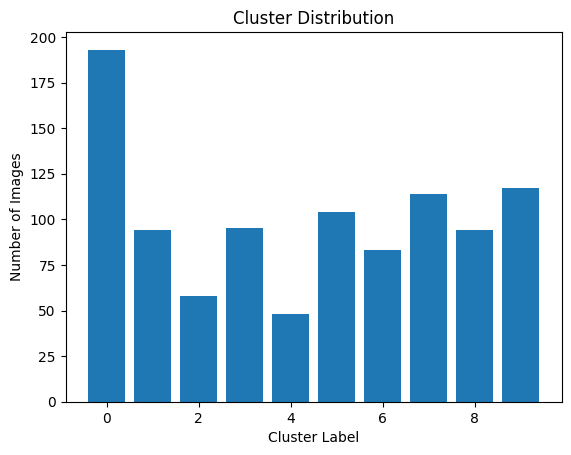

In [123]:
unique_labels, counts = np.unique(cluster_labels, return_counts=True)

plt.bar(unique_labels, counts)
plt.xlabel("Cluster Label")
plt.ylabel("Number of Images")
plt.title("Cluster Distribution")
plt.show()

We can see that the distribution is far from the original distribution we can see in the earlier plot. This is because the K-Means algorithm is trying to group the data points based on the pixel values, which may not necessarily correspond to the actual digit labels.

### 8.2 Visualization Using PCA for Dimensionality Reduction

Purpose: See if clusters visually separate in a reduced 2D space (PCA can help here).

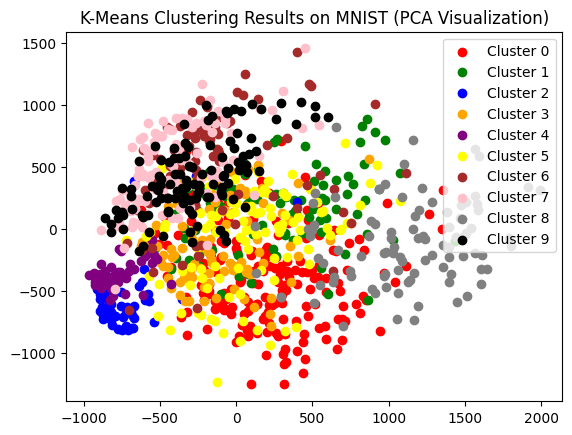

In [124]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)  # Assuming X is your image data (NumPy array)

colors = ['red', 'green', 'blue', 'orange', 'purple', 'yellow', 'brown', 'pink', 'gray', 'black']  

for cluster_id in range(10):
    cluster_indices = np.where(cluster_labels == cluster_id)
    plt.scatter(X_reduced[cluster_indices, 0], 
                X_reduced[cluster_indices, 1],
                c=colors[cluster_id], label=f"Cluster {cluster_id}")

plt.legend()
plt.title("K-Means Clustering Results on MNIST (PCA Visualization)")
plt.show()


here we can see that the clusters are not well separated in the 2D space.

### 8.3 Displaying Sample Images From Clusters

Purpose: Directly inspect what kind of images are grouped together.

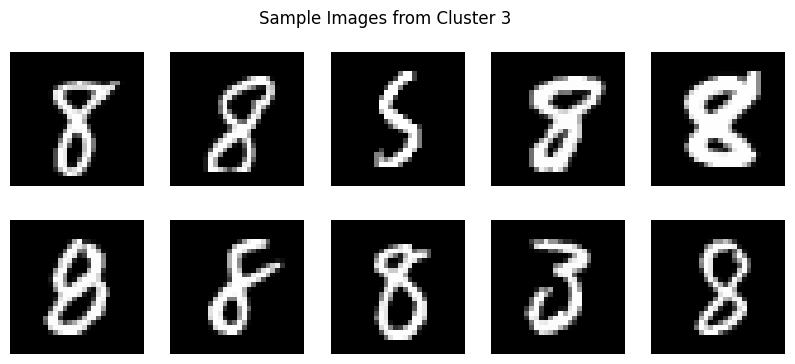

In [131]:
def display_cluster_images(cluster_id, n_images=10):
    cluster_indices = np.where(cluster_labels == cluster_id)[0]
    np.random.seed(40)  # For reproducibility
    sample_indices = np.random.choice(cluster_indices, n_images, replace=False)
    
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 4))  # Adjust if you want a different grid 
    
    for i, ax in enumerate(axes.flat):
        if i < n_images:
            image = preprocessed_img[sample_indices[i]].reshape(28, 28)
            ax.imshow(image, cmap='gray')
            ax.axis('off')
        else:
            ax.set_visible(False)  # Hide unused axes 
    plt.suptitle(f"Sample Images from Cluster {cluster_id}")
    plt.show()

# Example usage:
display_cluster_images(cluster_id=3, n_images=10)  

we can see that we are having quite mix images in the cluster as without proper feature extraction the K-Means algorithm is not able to group the images properly.

In [126]:
silhouette_score(preprocessed_img, cluster_labels)

0.03492743165993673

### 8.4 Plotting confusion metric

Confusion Matrix:
 [[ 3  0  2  0  0  0  5  0 90  0]
 [ 0  0 52  0 46  0  2  0  0  0]
 [ 1  1  0  0  0 95  2  0  1  0]
 [88  0  0  6  0  4  0  1  0  1]
 [ 1  0  3  0  1  1 50  1  0 43]
 [85  2  0 10  0  1  2  0  0  0]
 [ 1 90  1  1  0  0  6  0  1  0]
 [ 0  0  0  0  1  2  1 74  0 22]
 [12  1  0 76  0  1  4  2  2  2]
 [ 2  0  0  2  0  0 11 36  0 49]]


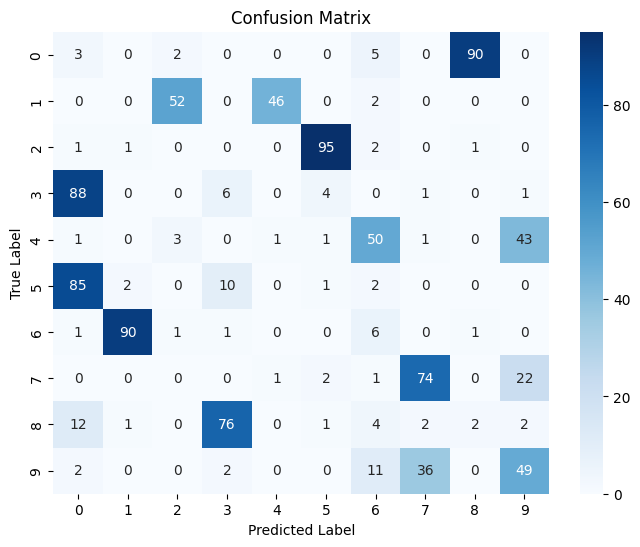

In [127]:
cm = confusion_matrix(y.astype('int'), cluster_labels)  # y_true are your true labels
print("Confusion Matrix:\n", cm)
plt.figure(figsize=(8, 6)) 
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')  # fmt='d' displays as integers
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

Here we can see that the clustering is improved for the numbers like 6, 2, 0, 8 which are bit different than any other number but now for similar looking images we need some more feature extraction along with some knowledge that 1 written in different manner like with left slanted or right slanted line with orientations.

# **9. Results and Conclusion** <a class="anchor" id="8"></a>

So, Here We have understood about K-Means clustering on image dataset.
- We learn to code k-means clustering from scratch.
- We understood about the MNIST dataset and visualized it.
- We applied K-Means clustering on raw image data and then applied feature selection using PCA and HOG.
- We visualized the clusters and confusion matrix for each case.
- We observed that the K-Means algorithm is not able to group the images properly when we use raw pixel values as features.
- We observed that the K-Means algorithm is able to group the images better when we use PCA for feature extraction.
- The best results were obtained when we used HOG for feature extraction. For numbers like 6, 2, 0, 8 the clustering is quite spot on. 
- But for similar looking images like (3, 5), (4, 7, 9) we need some more feature extraction along with some knowledge that 1 written in different manner like with left slanted or right slanted line with orientations.

# **10. References** <a class="anchor" id="10"></a>

Text Formatting: Gemini Advanced(model by google)

HOG Image credit:https://medium.com/@dnemutlu/hog-feature-descriptor-263313c3b40d

Kmeans clustering intuition image credit:https://www.analyticsvidhya.com/blog/2020/10/a-simple-explanation-of-k-means-clustering/